In [ ]:
import mpmath
from mpmath import mp, mpc, sqrt, exp, besselj, quad

mp.dps = 50  # set precision to 50 decimal places (arbitrary precision)
eps = 1e-3  # relative accuracy tolerance

def psi_powerlaw(x, amp, core, p):
    # x, amp, core, p are mpf/mpc types
    return amp * (x**2 + core**2)**(p / 2) - amp * core**p

def func_powerlaw(x, w, y, amp, core, p):
    # x: real integration variable (mpf)
    # w, y, amp, core, p: mpc or mpf
    sqrt2x = sqrt(2 * x)
    arg_bessel = w * y * sqrt2x
    bessel_val = besselj(0, arg_bessel)
    psi_val = psi_powerlaw(sqrt2x, amp, core, p)
    return bessel_val * exp(-1j * w * psi_val)

def func2_powerlaw(x, w, y, amp, core, p):
    return func_powerlaw(x, w, y, amp, core, p) * exp(1j * w * x)

def dfunc_powerlaw(x, w, y, amp, core, p):
    sqrt2x = sqrt(2 * x)
    psi_val = psi_powerlaw(sqrt2x, amp, core, p)
    J1 = besselj(1, w * y * sqrt2x)
    prefactor = -w * y / sqrt2x
    return prefactor * J1 * exp(-1j * w * psi_val) - (1j * w / (2 * x)) * func_powerlaw(x, w, y, amp, core, p)

def ddfunc_powerlaw(x, w, y, amp, core, p):
    sqrt2x = sqrt(2 * x)
    psi_val = psi_powerlaw(sqrt2x, amp, core, p)
    denom = (sqrt2x**2 + core**2)**(1 - p/2)
    dpsi = amp * p * sqrt2x / denom
    
    # derivative squared term:
    d2psi = amp * p * (1 - p / 2) * (2 * x)**(-0.5) * (1 - 2 * x / (2 * x + core**2)) / (2 * x + core**2)**(1 - p/2)
    
    term1 = (w * y) / (2 * x * sqrt2x) * (2 + 1j * w) * besselj(1, w * y * sqrt2x) * exp(-1j * w * psi_val)
    term2 = -1 / (2 * x) * (w**2 * y**2 - 1j * w / x) * func_powerlaw(x, w, y, amp, core, p)
    term3 = -1j * w / (2 * x) * dfunc_powerlaw(x, w, y, amp, core, p)
    return term1 + term2 + term3

def PowerLawAmplification(w, y, amp, core, p):
    a = 0.00001

    if w < 1 :
        b = 100 / w
    elif 1 < w < 500:
        b = 1000/w 
    else: b = 10000/w   
    #zzp = mpc(-1)
    
    
    # mpmath.quad with complex integrand
    zz = quad(lambda x: func2_powerlaw(x, w, y, amp, core, p), [a, b], error=True, maxdegree=10)
    zz_val = zz[0]  # integral value
    
    # Add tail correction terms (at b)
    tail = (-func_powerlaw(b, w, y, amp, core, p) / (1j * w) * exp(1j * w * b)
            - dfunc_powerlaw(b, w, y, amp, core, p) / (w**2) * exp(1j * w * b)
            + ddfunc_powerlaw(b, w, y, amp, core, p) / (1j * w**3) * exp(1j * w * b))
    
    zz_val += tail
        
    return -1j * w * exp(0.5 * 1j * w * y**2) * zz_val

# Example usage (set parameters as mpmath floats or complex numbers):
mp.dps = 50  # decimal digits precision
w = mp.mpf('150')
y = mp.mpf('0.5')
amp = mp.mpf('1.0')
core = mp.mpf('0')
p = mp.mpf('1')

result = PowerLawAmplification(w, y, amp, core, p)
print(result)


(1.2211212648626886147182851034440395140089698942484 + 0.24839758974169655434321251179541422395938854173764j)


In [78]:
def PL(w,y,amp,core,p):
    mp.dps = 50
    F = []

    for i in range(len(w)):
        result = PowerLawAmplification(w[i],y,amp,core,p)
        F.append(result)
        print(result)
    return F

In [ ]:
import time
mp.dps = 30  # desired precision

# Create a list of mpmath floats for w
w_values = [mp.mpf(x) for x in mpmath.linspace('0.001', '30', 1000)]

y = mp.mpf('0.1')
amp = mp.mpf('1.0')
core = mp.mpf('0.')  # note: core=0 is valid
p = mp.mpf('1.')

F = []
start = time.time()
with open("sis_y01.txt","w") as f:
    print("Processing....")
    for w in w_values:
        val = PowerLawAmplification(w, y, amp, core, p)
        xreal  = round(float(val.real),4)
        ximag = round(float(val.imag),4)
        f.write(f"{w}\t {xreal}\t{ximag} \n")
        #F.append(x)
print("File written")
print("Finished in ",time.time() - start,"s" )

Processing....


In [92]:
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mp, mpc, exp, pi, gamma, factorial, hyp1f1, nstr
def calculate_F(w, y, n_lim, epsilon=1e-30):
    # Convert inputs to mpmath-compatible complex numbers
    w = mpc(w)
    y = mpc(y)
    
    const = exp(0.5j * w * y**2)
    result = mpc(0)

    for n in range(n_lim):
        try:
            gamma_term = gamma(1 + n/2) / factorial(n)
            exponent = (2 * w * exp(pi * 3j / 2))**(n/2)
            hyp_term = hyp1f1(1 + n/2, 1, -0.5j * w * y**2)
            term = gamma_term * exponent * hyp_term
            result += term

            if abs(term) < epsilon:
                break  # early convergence
        except Exception as e:
            print(f"Error at n={n}: {e}")
            return -1
    
    return result * const

def SIS(w_range, y, n_lim):
    F_sis_an = []
    for ww in w_range:
        tmp = calculate_F(ww, y, n_lim)
        if tmp == -1:
            break
        else:
            # Convert mpmath complex number to Python native complex
            F_sis_an.append(complex(tmp))
    return np.array(F_sis_an, dtype=complex)

Fan = np.abs(SIS(w_values,0.5,2000))



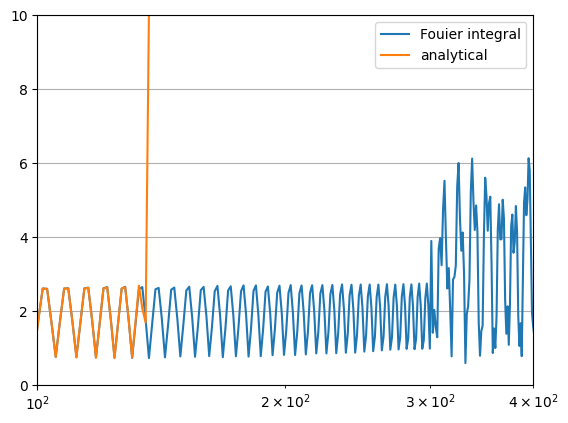

In [95]:
plt.plot(w_values,np.abs(F),label="Fouier integral")
plt.plot(w_values,Fan, label="analytical")
plt.xscale("log")
plt.xlim(100,400)
plt.ylim(0,10)
plt.legend()
plt.grid()

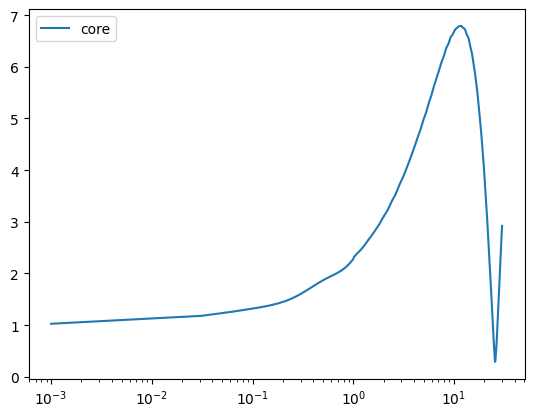

In [126]:
d = np.loadtxt("siscore_b01_y01.txt")
d1 = np.loadtxt("sis_y01.txt")

w  = d[:,0]
freal = d[:,1]
fimag = d[:,2]

w1 = d1[:,0]
fr1 = d1[:,1]
fi1 = d1[:,2]

F1 = fr1+1j*fi1
F = freal + 1j*fimag

plt.semilogx(w, np.abs(F),label="core")
#plt.semilogx(w1, np.abs(F1),label="sis")
plt.legend()


In [122]:
import multiprocessing
from mpmath import mp
#from your_module import PowerLawAmplification  # Make sure it's defined at top-level

def compute_amplification(w):
    y, amp, core, p = 1, 1, 0, 2  # example parameters
    mp.dps = 50  # Set precision inside each process
    val = PowerLawAmplification(w, y, amp, core, p)
    real = round(float(val.real), 4)
    imag = round(float(val.imag), 4)
    return (w, real, imag)

if __name__ == "__main__":
    mp.dps = 50  # Optional: for consistency in the main process
    w_values = [mp.mpf(x) for x in mpmath.linspace('0.001', '30', 100)]

    num_procs = 4  # 👈 You can change this to the number of cores you want to use

    with multiprocessing.Pool(processes=num_procs) as pool:
        results = pool.map(compute_amplification, w_values)

with open("w_amplification.txt", "w") as f:
    f.write("w\treal\timag\n")
    for w, real, imag in results:
        f.write(f"{float(w):.4f}\t{float(real):.4f}\t{float(imag):.4f}\n")
